In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize

In [3]:
from TVA1_UU import TVA1_UU

In [4]:
bhdvcs = TVA1_UU()

In [277]:
data = pd.read_csv('dvcs_psuedo.csv')
#data['#Set'] -= 1

In [132]:
data = addF1F2(data)

In [6]:
import utilities as uts
from tqdm import tqdm

In [75]:
def produceLHS(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    bh = bhdvcs.GetBHUUxs(data['phi_x'], data['F1'], data['F2'])
    a, b = bhdvcs.AB(data['phi_x'], data['F1'], data['F2'])
    return -(data['QQ'] * np.abs(data['t']))/( 2. * np.pi * bhdvcs.Gamma * b * bhdvcs.GeV2nb) * (data['F'] - bh - data['dvcs'])

In [77]:
def produceLHSerr(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    err = data['errF']
    err /= bhdvcs.Gamma
    err *= data['QQ']
    err *= np.abs(data['t'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    err /= b
    return np.abs(err)

In [78]:
def aoverb(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    return a/b

In [79]:
def linear_curve_fit(data, ReH, ReE):
    bhdvcs.SetKinematics(data[:, 0], data[:, 1], data[:, 2], data[:, 3])
    a, b = bhdvcs.ABcon(data[:, 4], data[:, 5], data[:, 6])
    #tau = -data['t']/(4*bhdvcs.M2)
    gm = data[:, 5] + data[:, 6]
    return (a/b)*(data[:, 5]*ReH + bhdvcs.tau*data[:, 6]*ReE) + gm*(ReH + ReE)

In [80]:
def combined_function_chisq(cffs, data):
    ReH, ReE, ReHtilde = cffs
    dftu = data.copy()
    dftu['F'] = bhdvcs.TotalUUXS(np.array(data[['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]), ReH, ReE, ReHtilde)
    yhat1 = produceLHS(dftu, bhdvcs)
    X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
    yhat2 = linear_curve_fit(X, ReH, ReE)
    chisq1 = np.sum(((yhat1 - data['F'])/data['errF'])**2)
    chisq2 = np.sum(((yhat2 - data['F'])/data['errF'])**2)
    return (chisq1 + chisq2)/2

In [83]:
def adjustForLine(data):
    high = data.copy()
    high['F'] = high['F'] + high['errF']
    cp = data.copy()
    cp['errF'] = np.abs(produceLHS(high, bhdvcs) - produceLHS(cp, bhdvcs))
    
    cp['F'] = produceLHS(cp, bhdvcs)
    
    return cp

In [90]:
def addF1F2(data):
    cp = data.copy()
    f1f2 = uts.f1_f2()
    cp['F1'] = f1f2.ffF1(cp['t'])
    cp['F2'] = f1f2.ffF2(cp['t'])
    return cp

# DVCS fit

In [315]:
def produceResults(data, numSets):
    '''
    :param data: data of class DvcsData (which can be found in utilities.py)
    :param numSets: number of different kinematic sets contained in data
    :param numReplicas: number of replicas you would like to produce
    
    :returns: numpy array with shape (numSets, numReplicas, numCFFs)
    '''
    results = []
    errs = []
    for i in range(numSets):
        #replicas = []
        seti = data.loc[data['#Set'] == i, :] # DvcsData object of kinematic set i
        X = np.array(seti.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2']]) # the kinematics and all variables necessary to compute 
        sigma = seti.loc[:, 'errF'] # error in F
        pars = np.array([1, 1, 1, .02])
        #for i in range(numReplicas):
            #y = seti.sampleY()
        y = seti.loc[:, 'F']
        cff, cffcov = optimize.curve_fit(bhdvcs.TotalUUXSFitJlab, X, y, pars, sigma, method='lm')
        print(cff, np.diag(cffcov))
        results.append(list(cff))
        errs.append(list(np.diag(cffcov)))
    return np.array(results), np.array(errs)


In [316]:
res, err = produceResults(data, 15)

[ 5.82774822e+01 -9.84650212e+02  4.12337105e+02  2.27154010e-02] [1.22387906e+02 2.85055968e+04 4.67624085e+03 9.92594403e-07]
[-1.14125150e+01  1.81248189e+02 -1.99038545e+01  2.50674595e-02] [3.72808900e+00 2.18866709e+03 1.16801609e+02 8.75055171e-07]
[-2.81949371e+01  1.11658079e+03 -3.85083695e+02  1.60544468e-02] [1.45356407e+02 1.72414539e+05 2.12994781e+04 4.65917054e-07]
[ 9.00188701e+00 -2.35807817e+02  1.24182440e+02  1.36617891e-02] [1.29448145e+00 3.86690522e+03 1.12086608e+03 3.31854329e-07]
[ 1.37374654e+01 -2.82905821e+02  1.37970122e+02  1.39572639e-02] [7.26352980e+00 1.56422976e+03 3.03467355e+02 1.99503639e-07]
[ 6.84513742e+00 -1.15732301e+02  5.74758317e+01  1.11485999e-02] [1.05903422e+00 6.52555967e+02 1.39727006e+02 1.42759798e-07]
[-1.74835525e+01  1.85991626e+02 -2.22154115e+01  1.39538313e-02] [2.05669050e+01 5.15893290e+03 2.44483540e+02 3.43784975e-07]
[ 5.93746171e+00 -1.11992282e+02  6.54174664e+01  1.07048720e-02] [3.34964062e-01 6.22823034e+02 2.44138

In [228]:
dset1 = data.loc[data['#Set'] == 0, :]

In [232]:
yhat = bhdvcs.TotalUUXSFitJlab(np.array(dset1.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2']]), *res[0, :])

yhatup = bhdvcs.TotalUUXSFitJlab(np.array(dset1.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2']]), *(res[0, :] + err[0, :]))
yhatdown = bhdvcs.TotalUUXSFitJlab(np.array(dset1.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2']]), *(res[0, :] - err[0, :]))

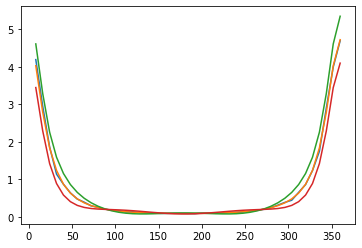

In [233]:
plt.plot(dset1['phi_x'], dset1['F'])
plt.plot(dset1['phi_x'], yhat, )
plt.plot(dset1['phi_x'], yhatup)
plt.plot(dset1['phi_x'], yhatdown)
plt.show()

In [317]:
data = data.drop('dvcs', axis='columns')

KeyError: "['dvcs'] not found in axis"

In [318]:
dvcs = pd.DataFrame({'dvcs': res[:, 3], '#Set': list(range(15))})

In [319]:
datawdvcs = data.merge(dvcs)

# Line Fit

In [320]:
adj = adjustForLine(datawdvcs)

In [321]:
def linear_curve_fit(data, ReH, ReE):
    bhdvcs.SetKinematics(data[:, 0], data[:, 1], data[:, 2], data[:, 3])
    a, b = bhdvcs.AB(data[:, 4], data[:, 5], data[:, 6])
    #tau = -data['t']/(4*bhdvcs.M2)
    gm = data[:, 5] + data[:, 6]
    return (a/b)*(data[:, 5]*ReH + bhdvcs.tau*data[:, 6]*ReE) + gm*(ReH + ReE)

In [322]:
def produceResultsLin(data, numSets):
    '''
    :param data: data of class DvcsData (which can be found in utilities.py)
    :param numSets: number of different kinematic sets contained in data
    :param numReplicas: number of replicas you would like to produce
    
    :returns: numpy array with shape (numSets, numReplicas, numCFFs)
    '''
    results = []
    errs = []
    for i in range(numSets):
        #replicas = []
        seti = data.loc[data['#Set'] == i, :] # DvcsData object of kinematic set i
        X = np.array(seti.loc[:, ['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']]) # the kinematics and all variables necessary to compute 
        sigma = seti.loc[:, 'errF'] # error in F
        pars = np.array([3, 3])
        #for i in range(numReplicas):
            #y = seti.sampleY()
        y = seti.loc[:, 'F']
        cff, cffcov = optimize.curve_fit(linear_curve_fit, X, y, pars, sigma, method='lm')
        print(cff, np.diag(cffcov))
        results.append(list(cff))
        errs.append(list(np.diag(cffcov)))
    return np.array(results), np.array(errs)

In [323]:
cffs, var = produceResultsLin(adj, 15)

[-8.07619113 29.62603875] [ 0.31837336 28.75675419]
[-8.062319   97.40063097] [ 0.16423419 27.48972853]
[ 3.4341467  25.05595856] [0.03282282 4.96559559]
[  4.96607783 -10.25228326] [0.02789601 3.79540868]
[-7.74611656 32.59817276] [ 0.16399065 14.15432781]
[2.0379635  5.04903963] [0.02001752 2.05677676]
[-11.24783881  86.25471812] [ 0.25124062 30.42832943]
[  3.67172116 -11.34635072] [0.01655442 1.88329755]
[-7.00235023 21.53346925] [ 0.23106624 17.36066276]
[0.53821237 2.15478438] [0.03108233 2.82154315]
[1.25202033 2.76075917] [0.01467072 1.44054545]
[-9.63551534 46.14421897] [ 0.19105687 15.50623231]
[0.07033577 2.54610306] [0.0245098  2.31658195]
[0.81166587 2.19317739] [0.01207156 1.23567555]
[-8.90452789 37.07357554] [ 0.1878156  13.59096592]


# Combined Fit

In [324]:
def combined_function_chisq(cffs, data):
    ReH, ReE, ReHtilde = cffs
    dftu = data.copy()
    dftu['F'] = bhdvcs.TotalUUXS(np.array(data[['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]), ReH, ReE, ReHtilde)
    yhat1 = produceLHS(dftu, bhdvcs)
    X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
    yhat2 = linear_curve_fit(X, ReH, ReE)
    chisq1 = np.sum(((yhat1 - data['F'])/data['errF'])**2)
    chisq2 = np.sum(((yhat2 - data['F'])/data['errF'])**2)
    return (chisq1 + chisq2)/2

In [337]:
data = datawdvcs.loc[(datawdvcs['#Set'] == 0), :]

In [338]:
x0 = np.array([1, 1, 1])
optimize.minimize(combined_function_chisq, x0, args=data)

KeyboardInterrupt: 

In [339]:
def produce_results_comb(data, numSets):
    results = []
    errs = []
    for i in range(numSets):
        seti = data.loc[data['#Set'] == i, :] # DvcsData object of kinematic set i
#         X = np.array(seti.loc[:, ['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']]) # the kinematics and all variables necessary to compute 
#         sigma = seti.loc[:, 'errF'] # error in F
#         pars = np.array([3, 3])
        x0 = np.array([1, 1, 1])
        minres = optimize.minimize(combined_function_chisq, x0, args=seti)
#         y = seti.loc[:, 'F']
#         cff, cffcov = optimize.curve_fit(linear_curve_fit, X, y, pars, sigma, method='lm')
        print(minres['x'], np.diag(minres['hess_inv']))
        results.append(list(minres['x']))
        errs.append(list(minres['hess_inv']))
    return np.array(results), np.array(errs)

In [340]:
r, v = produce_results_comb(datawdvcs, 15)

[-0.00707702  0.04117254  0.00022314] [5.60669345e-10 4.34445946e-10 3.75188722e-10]
[-0.00948647  0.03213672 -0.00236814] [6.09933623e-09 1.92651950e-06 2.21336338e-07]
[-5.06150117e-03  7.14139968e-04  4.25027583e-05] [1.10968261e-09 8.88814156e-07 9.26162229e-08]
[-0.00349281 -0.00675626  0.00016977] [6.06789185e-10 1.27268545e-08 7.62307188e-08]
[-0.00449349  0.02805575  0.0001202 ] [4.25179513e-11 5.23126000e-11 1.36812778e-11]
[-0.0029159   0.00632728  0.00032902] [3.67152100e-10 9.90304357e-08 4.34222401e-08]
[-0.00497174  0.01926899 -0.00068833] [1.37420812e-10 2.26917892e-10 1.60131589e-10]
[-0.00231296 -0.00123792  0.00015162] [9.18725950e-10 7.75593433e-08 7.62878377e-08]
[-0.00318391  0.02513331 -0.00028721] [6.75239543e-09 7.92963250e-07 3.10328758e-07]
[-0.002276    0.00935691  0.00031578] [2.22672247e-10 3.56651234e-08 1.98345319e-08]
[-0.0021174   0.00721788  0.00028701] [1.58724122e-10 6.25601690e-08 9.34300546e-08]
[-0.0033748   0.01964268  0.00014659] [8.45422418e-10